In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
train_list_file = 'SFootBD/IndexFiles/LstTrain'

In [29]:
train_list = pd.read_csv(train_list_file, sep = ' ', header = None)

In [42]:
import os
import scipy.io

mat_file = os.path.join('SFootBD/SFootBD', train_list[1][0] + '.mat')

mat = scipy.io.loadmat(mat_file)

In [43]:
import scipy.signal

def foot_reshape(arr):
    arr = np.append(arr, np.zeros((arr.shape[0], 3)), axis = 1)
    
    return np.reshape(arr, (arr.shape[0], 13, 7))

def prepare_data(matrix):
    dataL = foot_reshape(mat['dataL'])
    dataR = foot_reshape(mat['dataR'])
    
    data = np.append(dataL, dataR, axis = 2)
    
    # Downsample using order 8 Chebyshev type I filter
    #data = scipy.signal.decimate(data, 6, axis = 0)
    
    return data

In [44]:
data = prepare_data(mat)

print data.shape

(2200L, 13L, 14L)


In [45]:
Tmax = 1600

spatial = data[:Tmax]

spatial = np.sum(np.abs(spatial), axis = 0)

spatial.shape

(13L, 14L)

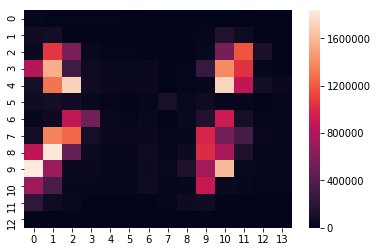

In [46]:
import seaborn as sns

sns.heatmap(spatial)